# Assignment 4
*By Ryan Cox*

In [243]:
using LinearAlgebra
using Plots.Measures
using MAT
using Statistics

## Q1

In [ ]:
"""
Structure for storing results of the tomography fitting.
"""
struct SVDAnalysis
     G::Matrix
     d::Vector # Observed
     dStd::Real
     m::Vector # Estimated
     covM::Matrix
     fig::Any # plot
     p::Integer
end


"""
Use singular value decomposition to solve an inverse problem described by G.
Based on TomographyFit() written for Assignment 3.

Parameters
        G::Matrix - Model kernel
        dObs::Vector - Observed data
        dStd::Real - Standard deviation of data
        p::Integer - Number of singular values considered

Returns as SVDAnalysis
"""
function SVDFit(G::Matrix, dObs::Vector, dStd::Real, p::Integer=-1)::SVDAnalysis
    # Decompose kernel G into U, S and V such that G = U * Diagonal(S) * Vt
    decomposition = svd(G)
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V

    p = p < 0 ? length(S) : p # Use length(S) for p unless p specifically set in function call
    Sp = S[1:p] # Truncate component matrices
    Up = U[:,1:p]
    Vp = V[:,1:p]

    # Estimate parameters, their covariance
    mEst = Vp * ((transpose(Up) * dObs) ./ Sp)
    covM = dStd^2 * Vp * (Diagonal(Sp)^(-2)) * transpose(Vp)

    # prepare plots
    fig = plot(dObs, seriestype=:scatter, yerror=dStd, markerstrokecolor=:auto, label="Observed data", xlabel="index", ylabel="time (s)", title=label)
    fig = plot!(G * mEst, label="Predicted data")

    SVFAnalysis(G, dObs, dStd, mEst, covM, fig, p)
end

First let us load our data. We'll then plot all the seismograms together, just to demonstrate their similarity. This graph is useless for anything else, although it has a certain asthetic appeal.

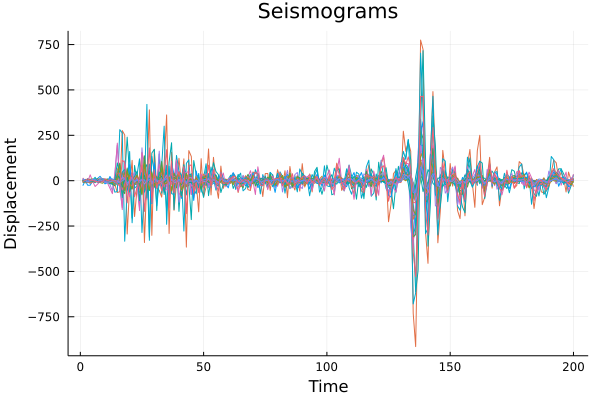

In [90]:
seismograms = matread("C:\\Users\\Ryan's PC\\github\\math322-inverse-theory\\seismograms.mat.mat")["seismograms"]
# I assume the format of the data is that each row is single seismogram.
# Each value is a displacement  and they are ordered chronoloigcally over some timescale?

"""
Plots the seismogram matrix such that all the seismograms are overlaid.
"""
function plotSeismogramMatrix(S::Matrix)::Plots.Plot
    # Setup a variable to store the plots
    p = plot(legend=false, xlabel="Time", ylabel="Displacement", title="Seismograms") # I don't know what the units are
    # Loop over all the seismograms
    for row in 1:size(S)[1]
        p = plot!(S[row,:])
    end
    return p
end

plotSeismogramMatrix(seismograms)

Now we will perform singular value decomposition on the data. Heatmap representations of V are used to illustrate its structure. Singular values are also displayed, plotted against their indicies.

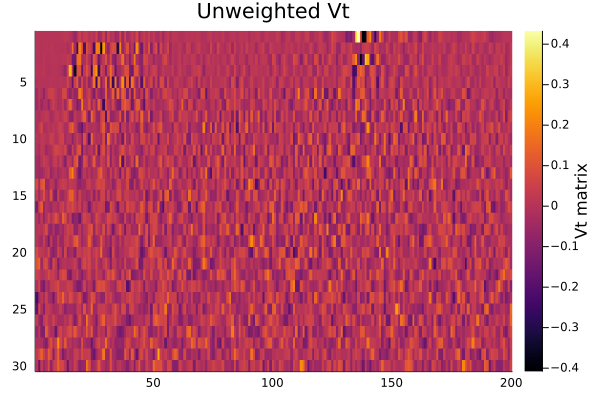

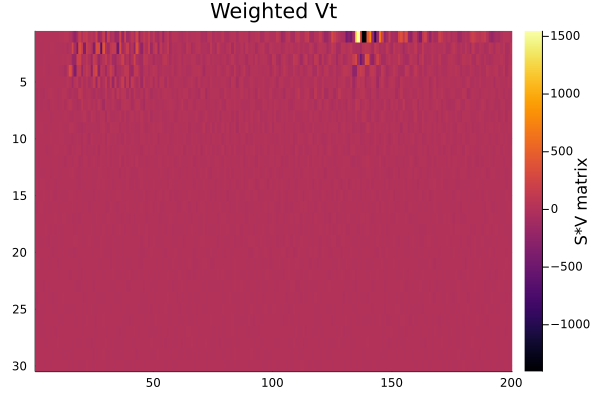

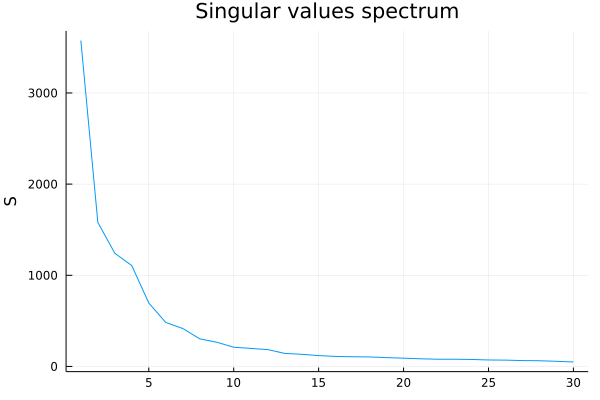

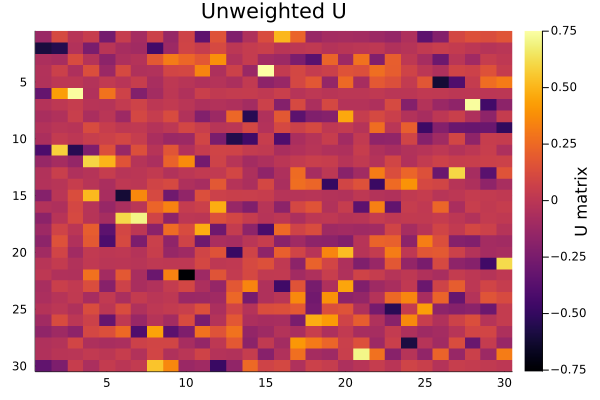

In [76]:
decomposition = svd(seismograms)
U = decomposition.U
S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
V = decomposition.V
Vt = decomposition.Vt # transpose of V

unweighted = heatmap(Vt, title="Unweighted Vt", yflip=true, colorbar_title="Vt matrix")
weighted = heatmap(diagm(S)*Vt, title="Weighted Vt", yflip=true, colorbar_title="S*V matrix")

display(unweighted)
display(weighted)

display(plot(S, title="Singular values spectrum", ylabel="S", legend=false))
display(heatmap(U, title="Unweighted U", yflip=true, colorbar_title="U matrix"))

Now we'll plot various approximations together with the actual result. I've plotted them very large so that the differences in lines are more apparent.

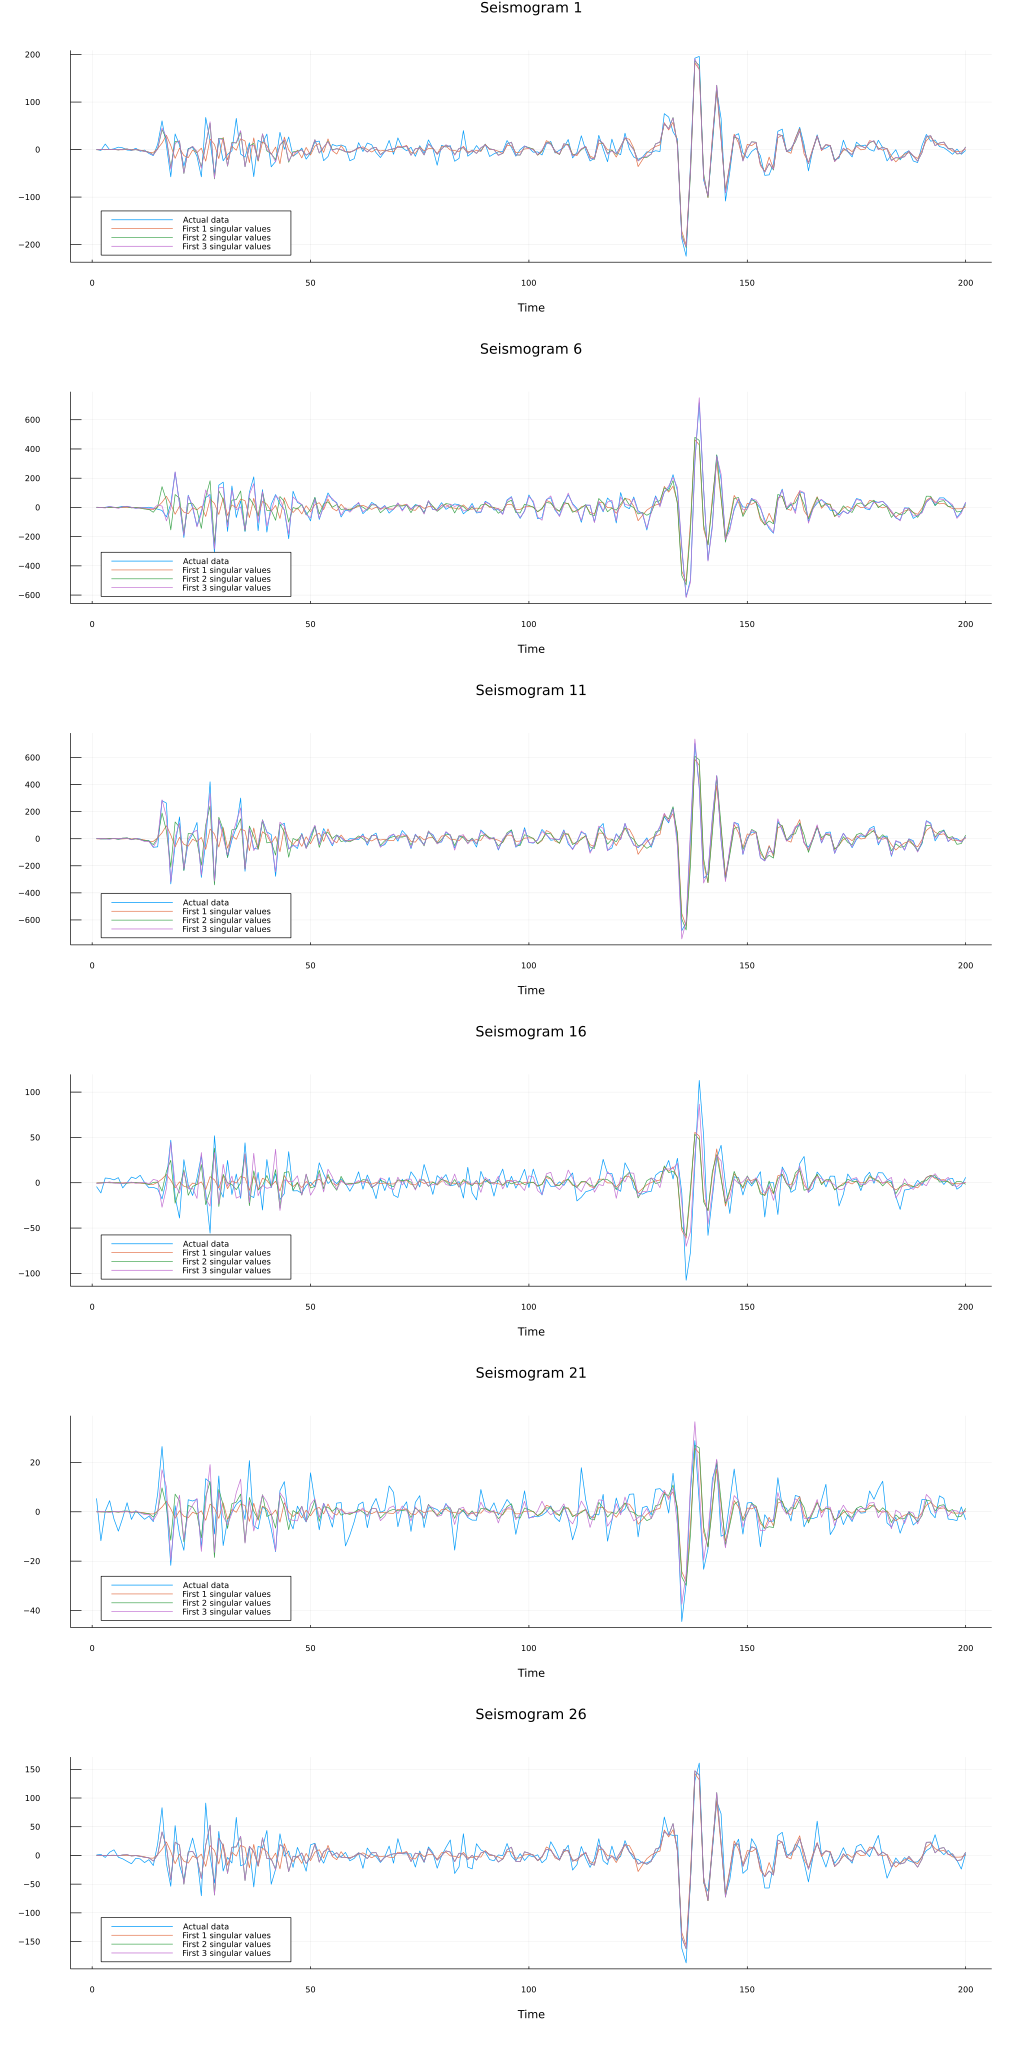

In [175]:
# Just a custom type for storing U_p * S_p * V_p^T
struct ApproxMatrix
    mat::Matrix
    p::Int # First p singular values used to make mat
end

"""
Generate an approximation of the seismogram matrix using the first p singular values
"""
function approximateMatrix(U::Matrix, S::Vector, Vt::Matrix, p::Integer)::ApproxMatrix
    # Truncate component matrices
    Up = U[:,1:p]
    Sp = S[1:p] 
    Vtp = Vt[1:p,:]
    # Save as our custom type
    ApproxMatrix(Up*diagm(Sp)*Vtp, p)
end


"""
Plot a single seismogram (matrix row) with actual value and several p values.
"""
function plotSeismogram(row::Int, actualMatrix::Matrix, approxMatrices::Vector{ApproxMatrix})::Plots.Plot
    actual = actualMatrix[row,:]
    fig = plot(actual, title="Seismogram $row", xlabel="Time", ylabel="Displacement", label="Actual data", legend=:bottomleft)
    for approx in approxMatrices
        plot!(approx.mat[row,:], label="First $(approx.p) singular values")
    end
    return fig
end


# Each element p in this list causes an approximation to be generated with the first p singular values
pValues = [1,2,3]

approxMatrices = approximateMatrix.(Ref(U), Ref(S), Ref(Vt), pValues) # refs mean only pValues is broadcast

plotRange = 1:5:30 # row indicies of the seismograms to display

figures = plotSeismogram.(plotRange, Ref(seismograms), Ref(approxMatrices))

plt = plot(figures..., layout=(6, 1), size=(1500, 3000), margin=10mm)

display(plt)

*NB: For mysterious reasons the y-axis label is being cut off, but it *should* show "Displacement" as a label.*

I decided to show the synthesis results on top of the raw data because it makes it easier to compare than an array of subplots, at least when the plot is big enough that variation is distinct. We can see that even one or two values is enough to roughly approximate the data. With three values we can get some very good matches, such as the right of seisogram 6 and some poorer matches, as in the start of seismogram 26. The approximations match peak positions fairly reliably but the peak amplutude is more commonly flawed. Large amplitude changes seem to be better approximated than small ones, so the envelopes of large variation tend to be more accurate than the surronding calmer regions.

## Q2

As the very helpful location notes explain, the trick is peturbing the model. Arrival time $d_i$ is
$$d_i = \frac{1}{\alpha} \left[ (x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2 \right]^{1/2} + t$$
where $(x,y,z)$ is the position of the station, $x_i,y_i,z_i)$ is the position of the hypocentre and $t$ is a constant adjustment to the time.

We can linearise this by first peturbing it from a starting point, $d_i^o$
$$d_i = d_i^o + \sum_j \frac{\partial d_i}{\partial m_j}$$
$$\Delta d_i = d_i - d_i^o = \sum_j \frac{\partial d_i}{\partial m_j}$$
$$\Delta \vec{d} = G \Delta\vec{m} \quad \text{where } G_{ij} = \frac{\partial d_i}{\partial m_j}$$

The derivatives for the spatial parameters are of the form
$$G_{i1} = \frac{\partial d_i}{\partial m_j} = \frac{\partial d_i}{\partial x} = \frac{x-x_i}{\alpha} \left[ (x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2 \right]^{-1/2}$$
and for the temporal parameter
$$G_{i4} = \frac{\partial d_i}{\partial m_4} = \frac{\partial d_i}{\partial t} = 1$$

With this we can begin our code. This time I'm going to work closely from the example code, which should prove a mildly interesting experiment in seeing how well MATLAB translates to Julia.

In [254]:
"""
Results of earthquake location function.

Attributes
    m::Vector{Float64} - Parameters found by fitting
        m[1] - x coordinate of earthquake hypocenter
        m[2] - y coordinate of earthquake hypocenter
        m[3] - z coordinate of earthquake hypocenter (should be positive)
        m[4] - original time of the earthquake
    i::Int - Number of iterations to achieve convergence
    outputMatrix::Matrix - Stores results of all iterations in form [iteration, parameters, perturbation]
"""
struct EQAnalysis
    m::Vector{Float64}
    i::Int
    outputMatrix::Matrix
end


"""
Locate an earthquake given P-wave arrival times in a uniform velocity environment.

Based on incomplete MATLAB sample code by John Townend. Translated to Julia and completed by Ryan Cox.

Parameters
    x::Vector - Seisometer locations, x coordinates
    y::Vector - Seisometer locations, y coordinates
    z::Vector - Seisometer locations, z coordinates
    tP::Vector - P-wave arrival times
    speed::Real - Speed of P-waves in medium. Defaults to six length units per time unit.

Returns EQAnalysis object
    
    
"""
function locateEQ(x::Vector, y::Vector, z::Vector, tP::Vector, speed::Real=6)::EQAnalysis
    # Prep some variables
    N = length(x) # Number of seisometers
    normdm = Inf # (squared) length of model perturbation \
    i=0 # iteration counter

    # Specify starting position
    m = [mean(x), mean(y), mean(z)+10, 0] # positive z is down and earthquakes tend to occur deeper than seisometers

    # Matrix to hold results
    #outputMatrix = [i m normdm] # iteration, parameters, perturbation
    outputMatrix = [1 1 1] # TEMP fix of borkedness

    # Prepare screen output
    println("Iteration | (x,y,z,t) | mormdm sqd ")
    println("$i | ($(m[1]), $(m[2]), $(m[3]), $(m[4])) | $normdm")

    # Iteratively peturb model
    while normdm >= 1e-5 # stopping criterion
        G = generateKernel(m, x, y, z, speed) # generate data kernel such that dd=G*dm
        R = hypodistance(m, x, y, z) # distance to current hypocenter
        d = (R / speed) .+ m[4] # predicted arrival time (travel time + origin time)
        dd = d - tP # residual arrival time
        Gg = inv(transpose(G)*G) * transpose(G) # generalised inverse of kernal
        dm = Gg * dd # model perturbation
        normdm = transpose(dm) * dm # (squared) length of perturbation
        m += dm # update model
        i += 1 # increment iteration counter
        println("$i | ($(m[1]), $(m[2]), $(m[3]), $(m[4])) | $normdm")
        # outputMatrix = [outputMatrix;i m normdm] # ~~inefficent in Julia, should be improved~~ BROKEN
    end

    return EQAnalysis(m, i, outputMatrix)
end


"""
Calculate hypocentral distance

Parameters
    m::Vector - Model parameters (x0,y0,zo,t0)
    x::Vector - Seisometer locations, x coordinates
    y::Vector - Seisometer locations, y coordinates
    z::Vector - Seisometer locations, z coordinates

Returns distance between hypocentre and each station as Vector
"""
function hypodistance(m::Vector, x::Vector, y::Vector, z::Vector)::Vector
    dx = x .- m[1]
    dy = y .- m[2]
    dz = z .- m[3]
    R = sqrt.(dx.^2 + dy.^2 + dz.^2)
end


"""
Generates kernel G from the travel time gradient.

Parameters
    m::Vector - Model parameters (x0,y0,zo,t0)
    x::Vector - Seisometer locations, x coordinates
    y::Vector - Seisometer locations, y coordinates
    z::Vector - Seisometer locations, z coordinates
    speed::Real - Speed of P-waves in medium

Returns kernel as Matrix
"""
function generateKernel(m::Vector, x::Vector, y::Vector, z::Vector, speed::Real)::Matrix{Float64}
    N = length(x)
    R = hypodistance(m, x, y, z)

    G = Matrix{Float64}(undef, (N, 4))
    G[:,1] .= (x .- m[1]) ./ (speed * R)
    G[:,2] .= (y .- m[2]) ./ (speed * R)
    G[:,3] .= (z .- m[3]) ./ (speed * R)
    G[:,4] .= 1

    return G
end


# Seismometer locations in kilometres
x = [40,20,0,40,20,0]
y = [40,40,40,0,0,0]
z = [0,0,0,0,0,0]
# The sample code doesn't include z but there is no reason we can't have seisometers distrubuted in that axis.

# O-wave arrival times in seconds
tP1=[4.16,3.36,5.83,6.68,6.27,7.75] # case 1
tP2=[12.46,15.77,19.09,13.65,16.74,19.90] # case 2
e=[0.1,-0.2,-0.3,0.2,0,0] # errors

m = locateEQ(x, y, z, tP1)

Iteration | (x,y,z,t) | mormdm sqd 
0 | (20.0, 20.0, 10.0, 0.0) | Inf
1 | (26.165, 29.881259499793643, 9.11591549683476, -1.154115805731403) | 137.76010300403811
2 | (26.00128925286169, 30.01538063509899, 8.09354402386958, -3.306105112861712) | 5.721091094400357
3 | (26.006398683084992, 30.018167108287233, 8.095992759652077, -7.606945887961748) | 18.49727123978005
4 | (26.006399057460595, 30.01816656103111, 8.095979911928481, -16.208628054861975) | 73.98893610053491
5 | (26.006399059020936, 30.018166562939662, 8.09597992540786, -33.41199238782853) | 295.9557443727859
6 | (26.006399059019692, 30.018166562937022, 8.09597992538987, -67.81872105376289) | 1183.8229774912286
7 | (26.00639905901989, 30.01816656293673, 8.095979925392484, -136.63217838563128) | 4735.291909964872
8 | (26.006399059018953, 30.01816656293676, 8.095979925382139, -274.2590930493682) | 18941.16763985952
9 | (26.006399059018783, 30.018166562938237, 8.095979925388505, -549.5129223768424) | 75764.67055943835
10 | (26.006

LoadError: SingularException(4)